Chargement du fichier data/matrice_routes_ordre.csv...

Paramètres du problème:
- Nombre de villes: 30
- Points de collecte: [25, 17]

Lancement de la comparaison...

=== Testing Genetic ===
Run 1: Cost=2362 Time=0.24s Valid=True
Run 2: Cost=2257 Time=0.25s Valid=True
Run 3: Cost=2357 Time=0.24s Valid=True
Run 4: Cost=2310 Time=0.23s Valid=True
Run 5: Cost=2286 Time=0.24s Valid=True

=== Testing Simulated Annealing ===
Run 1: Cost=1260 Time=0.04s Valid=True
Run 2: Cost=1009 Time=0.04s Valid=True
Run 3: Cost=986 Time=0.04s Valid=True
Run 4: Cost=1196 Time=0.04s Valid=True
Run 5: Cost=1408 Time=0.04s Valid=True

=== Testing Ant Colony ===
Run 1: Cost=857 Time=2.12s Valid=True
Run 2: Cost=855 Time=2.09s Valid=True
Run 3: Cost=758 Time=2.08s Valid=True
Run 4: Cost=776 Time=2.11s Valid=True
Run 5: Cost=890 Time=2.07s Valid=True


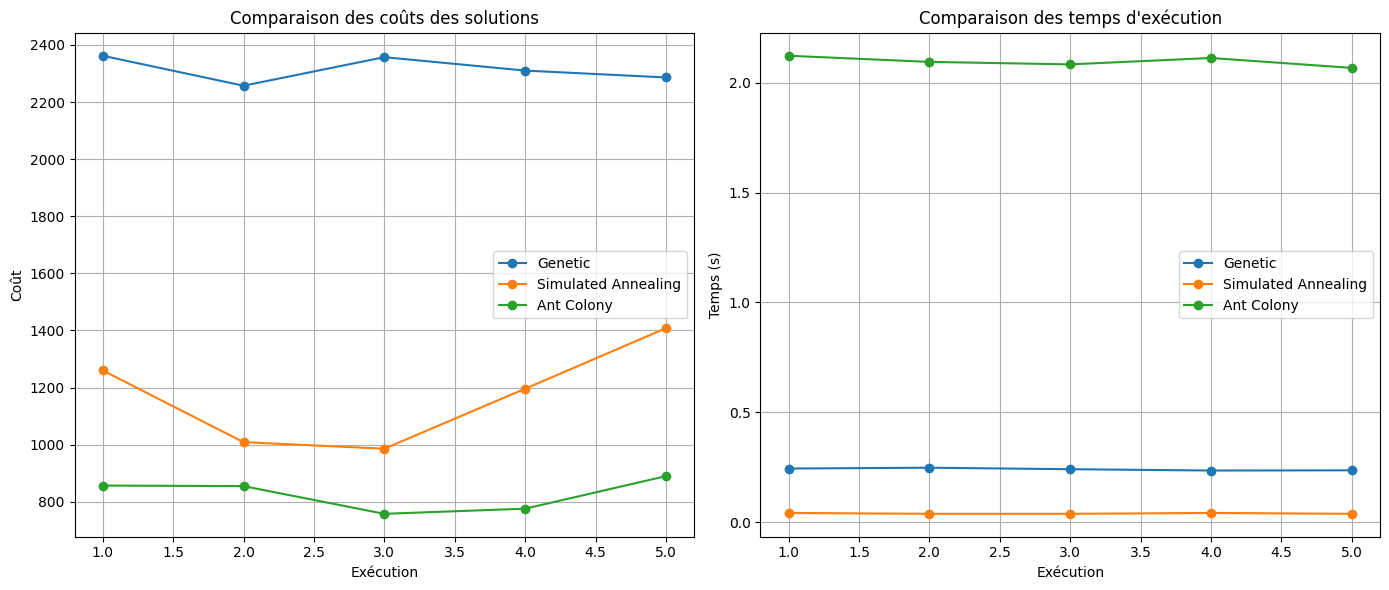


=== Statistiques Comparatives ===

Genetic:
  - Solutions valides: 5/5 (100.0%)
  - Coût moyen (valides): 2314.4 (+179.8% vs le meilleur)
  - Temps moyen (valides): 0.24s (+508.1% vs le plus rapide)

Simulated Annealing:
  - Solutions valides: 5/5 (100.0%)
  - Coût moyen (valides): 1171.8 (+41.7% vs le meilleur)
  - Temps moyen (valides): 0.04s (+0.0% vs le plus rapide)

Ant Colony:
  - Solutions valides: 5/5 (100.0%)
  - Coût moyen (valides): 827.2 (+0.0% vs le meilleur)
  - Temps moyen (valides): 2.10s (+5193.9% vs le plus rapide)


In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from typing import Tuple, List, Dict

def load_adjacency_matrix_and_collecte(file_path: str) -> Tuple[np.ndarray, List[int]]:
    """Charge la matrice d'adjacence et les points de collecte depuis un fichier CSV."""
    try:
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        points_collecte = list(map(int, lines[-1].split(';')))
        matrix = [list(map(int, line.split(';'))) for line in lines[:-1]]
            
        return np.array(matrix), points_collecte
        
    except FileNotFoundError:
        raise ValueError(f"Fichier {file_path} introuvable")
    except Exception as e:
        raise ValueError(f"Erreur lors de la lecture du fichier: {str(e)}")

class BaseTSP:
    """Classe de base avec les fonctionnalités communes"""
    def __init__(self, matrix: np.ndarray, collecte_points: List[int], start_node: int = 1):
        self.matrix = matrix
        self.collecte = set(collecte_points)
        self.start_node = start_node
        self.num_cities = len(matrix)
        self.best_solution = None
        self.best_cost = float('inf')
        
    def is_valid_path(self, path: List[int]) -> bool:
        if path is None:
            return False
        if (len(path) != self.num_cities + 1 or path[0] != self.start_node or path[-1] != self.start_node):
            return False
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
        if len(set(path)) != self.num_cities:
            return False
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
        return True

    def calculate_cost(self, path: List[int]) -> int:
        if path is None:
            return float('inf')
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

    def _generate_random_path(self) -> List[int]:
        """Génère un chemin aléatoire valide"""
        while True:
            path = [self.start_node]
            unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
            
            collect_candidates = [c for c in self.collecte if c in unvisited and 
                                self.matrix[self.start_node-1][c-1] != -1]
            if not collect_candidates:
                continue
                
            collect_point = random.choice(collect_candidates)
            path.append(collect_point)
            unvisited.remove(collect_point)
            
            while unvisited:
                last = path[-1]
                candidates = [c for c in range(1, self.num_cities+1) 
                            if c in unvisited and self.matrix[last-1][c-1] != -1]
                
                if not candidates:
                    break
                    
                next_city = random.choice(candidates)
                path.append(next_city)
                unvisited.remove(next_city)
            
            if not unvisited and self.matrix[path[-1]-1][self.start_node-1] != -1:
                path.append(self.start_node)
                if self.is_valid_path(path):
                    return path
        return None

class GeneticTSP(BaseTSP):
    """Algorithme génétique pour le TSP avec contraintes"""
    def solve(self, population_size: int = 50, generations: int = 100):
        population = [self._generate_random_path() for _ in range(population_size)]
        population = [p for p in population if p is not None]
        
        if not population:
            return None, float('inf')
        
        for _ in range(generations):
            population.sort(key=lambda x: self.calculate_cost(x))
            self.best_solution = population[0]
            self.best_cost = self.calculate_cost(population[0])
            
            new_population = []
            for _ in range(population_size):
                candidates = random.sample(population, min(3, len(population)))
                winner = min(candidates, key=lambda x: self.calculate_cost(x))
                new_population.append(winner.copy())
            
            for i in range(0, len(new_population)-1, 2):
                child1, child2 = self._crossover(new_population[i], new_population[i+1])
                if child1 and self.is_valid_path(child1):
                    new_population[i] = child1
                if child2 and self.is_valid_path(child2):
                    new_population[i+1] = child2
            
            population = new_population
        
        return self.best_solution, self.best_cost
    
    def _crossover(self, parent1: List[int], parent2: List[int]) -> Tuple[List[int], List[int]]:
        if len(parent1) <= 3 or len(parent2) <= 3:
            return parent1, parent2
            
        cut = random.randint(2, len(parent1)-2)
        child1 = parent1[:cut] + [x for x in parent2 if x not in parent1[:cut]]
        child2 = parent2[:cut] + [x for x in parent1 if x not in parent2[:cut]]
        
        if child1[-1] != self.start_node and self.matrix[child1[-2]-1][self.start_node-1] != -1:
            child1[-1] = self.start_node
        if child2[-1] != self.start_node and self.matrix[child2[-2]-1][self.start_node-1] != -1:
            child2[-1] = self.start_node
            
        return child1, child2

class SimulatedAnnealingTSP(BaseTSP):
    """Recuit simulé pour le TSP avec contraintes"""
    def solve(self, initial_temp: float = 10000, cooling_rate: float = 0.995):
        current_solution = self._generate_random_path()
        if current_solution is None:
            return None, float('inf')
            
        current_cost = self.calculate_cost(current_solution)
        self.best_solution = current_solution.copy()
        self.best_cost = current_cost
        temp = initial_temp
        
        while temp > 1:
            neighbor = self._get_neighbor(current_solution)
            if neighbor is None:
                continue
                
            neighbor_cost = self.calculate_cost(neighbor)
            
            if neighbor_cost < current_cost or random.random() < math.exp(-(neighbor_cost - current_cost)/temp):
                current_solution, current_cost = neighbor, neighbor_cost
                if current_cost < self.best_cost:
                    self.best_solution, self.best_cost = current_solution, current_cost
            
            temp *= cooling_rate
        
        return self.best_solution, self.best_cost
    
    def _get_neighbor(self, path: List[int]) -> List[int]:
        if len(path) <= 3:
            return path.copy()
            
        mutable = list(range(1, len(path)-1))
        if len(path) > 3:
            mutable.remove(1)
        if len(path) > 4:
            mutable.remove(len(path)-2)
            
        if len(mutable) < 2:
            return path.copy()
            
        i, j = random.sample(mutable, 2)
        new_path = path.copy()
        new_path[i], new_path[j] = new_path[j], new_path[i]
        
        return new_path if self.is_valid_path(new_path) else path.copy()

class ACO_TSP(BaseTSP):
    """Colonie de fourmis pour le TSP avec contraintes"""
    def solve(self, num_ants: int = 20, iterations: int = 100):
        self.pheromone = np.ones((self.num_cities + 1, self.num_cities + 1)) * 0.1
        best_global_solution = None
        best_global_cost = float('inf')
        
        for _ in range(iterations):
            solutions = []
            for _ in range(num_ants):
                solution = self._construct_ant_solution()
                if solution:
                    solutions.append(solution)
            
            if not solutions:
                continue
                
            for solution in solutions:
                cost = self.calculate_cost(solution)
                delta = 1.0 / cost
                for i in range(len(solution)-1):
                    self.pheromone[solution[i]][solution[i+1]] += delta
            
            current_best = min(solutions, key=lambda x: self.calculate_cost(x))
            current_cost = self.calculate_cost(current_best)
            
            if current_cost < best_global_cost:
                best_global_solution, best_global_cost = current_best, current_cost
        
        self.best_solution, self.best_cost = best_global_solution, best_global_cost
        return self.best_solution, self.best_cost
    
    def _construct_ant_solution(self) -> List[int]:
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        
        collect_candidates = [c for c in self.collecte if c in unvisited and 
                            self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
            
        probs = np.array([self.pheromone[self.start_node][c] / (self.matrix[self.start_node-1][c-1] or 1) 
                     for c in collect_candidates])
        probs = probs / probs.sum()
        first_collect = np.random.choice(collect_candidates, p=probs)
        path.append(first_collect)
        unvisited.remove(first_collect)
        
        while unvisited:
            last = path[-1]
            candidates = [c for c in unvisited if self.matrix[last-1][c-1] != -1]
            
            if not candidates:
                return None
                
            probs = np.array([self.pheromone[last][c] / (self.matrix[last-1][c-1] or 1) for c in candidates])
            probs = probs / probs.sum()
            next_city = np.random.choice(candidates, p=probs)
            path.append(next_city)
            unvisited.remove(next_city)
        
        if self.matrix[path[-1]-1][self.start_node-1] != -1:
            path.append(self.start_node)
            return path if self.is_valid_path(path) else None
        return None

def compare_algorithms(matrix: np.ndarray, collecte: List[int], start_node: int, runs: int = 5):
    """Compare les trois algorithmes sur plusieurs exécutions."""
    algorithms = {
        "Genetic": GeneticTSP,
        "Simulated Annealing": SimulatedAnnealingTSP,
        "Ant Colony": ACO_TSP
    }
    
    results = {name: {'costs': [], 'times': [], 'valid': []} for name in algorithms}
    
    for name, algorithm_class in algorithms.items():
        print(f"\n=== Testing {name} ===")
        for run in range(runs):
            solver = algorithm_class(matrix, collecte, start_node)
            start_time = time.time()
            
            try:
                if name == "Genetic":
                    solution, cost = solver.solve(population_size=50, generations=100)
                elif name == "Simulated Annealing":
                    solution, cost = solver.solve(initial_temp=10000, cooling_rate=0.995)
                else:  # ACO
                    solution, cost = solver.solve(num_ants=20, iterations=100)
                
                valid = solver.is_valid_path(solution)
            except Exception as e:
                print(f"Error in {name} run {run+1}: {str(e)}")
                solution, cost, valid = None, float('inf'), False
            
            exec_time = time.time() - start_time
            results[name]['costs'].append(cost if solution else float('inf'))
            results[name]['times'].append(exec_time)
            results[name]['valid'].append(valid)
            print(f"Run {run+1}: Cost={cost if solution else 'INF'} Time={exec_time:.2f}s Valid={valid}")
    
    # Calcul des moyennes et pourcentages
    stats = {}
    for name in algorithms:
        valid_costs = [c for c, v in zip(results[name]['costs'], results[name]['valid']) if v]
        valid_times = [t for t, v in zip(results[name]['times'], results[name]['valid']) if v]
        
        stats[name] = {
            'valid_count': sum(results[name]['valid']),
            'avg_cost': np.mean(valid_costs) if valid_costs else float('nan'),
            'avg_time': np.mean(valid_times) if valid_times else float('nan')
        }
    
    # Trouver les meilleures valeurs pour les pourcentages
    min_cost = min(s['avg_cost'] for s in stats.values() if not np.isnan(s['avg_cost']))
    min_time = min(s['avg_time'] for s in stats.values() if not np.isnan(s['avg_time']))
    
    # Affichage des résultats
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Graphique des coûts (commence à 1)
    for name in algorithms:
        costs = results[name]['costs']
        ax1.plot(range(1, runs+1), costs, 'o-', label=name)
    ax1.set_title('Comparaison des coûts des solutions')
    ax1.set_xlabel('Exécution')
    ax1.set_ylabel('Coût')
    ax1.legend()
    ax1.grid(True)
    
    # Graphique des temps (commence à 1)
    for name in algorithms:
        times = results[name]['times']
        ax2.plot(range(1, runs+1), times, 'o-', label=name)
    ax2.set_title('Comparaison des temps d\'exécution')
    ax2.set_xlabel('Exécution')
    ax2.set_ylabel('Temps (s)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des statistiques avec pourcentages
    print("\n=== Statistiques Comparatives ===")
    for name, data in stats.items():
        cost_diff = (data['avg_cost']/min_cost - 1)*100 if not np.isnan(data['avg_cost']) else float('nan')
        time_diff = (data['avg_time']/min_time - 1)*100 if not np.isnan(data['avg_time']) else float('nan')
        
        print(f"\n{name}:")
        print(f"  - Solutions valides: {data['valid_count']}/{runs} ({data['valid_count']/runs*100:.1f}%)")
        print(f"  - Coût moyen (valides): {data['avg_cost']:.1f}", 
              f"({cost_diff:+.1f}% vs le meilleur)" if not np.isnan(cost_diff) else "")
        print(f"  - Temps moyen (valides): {data['avg_time']:.2f}s",
              f"({time_diff:+.1f}% vs le plus rapide)" if not np.isnan(time_diff) else "")
    
    return results

if __name__ == "__main__":
    try:
        file_path = "data/matrice_routes_ordre.csv"  # À adapter
        print(f"Chargement du fichier {file_path}...")
        matrix, collecte = load_adjacency_matrix_and_collecte(file_path)
        
        print("\nParamètres du problème:")
        print(f"- Nombre de villes: {len(matrix)}")
        print(f"- Points de collecte: {collecte}")
        
        print("\nLancement de la comparaison...")
        comparison_results = compare_algorithms(matrix, collecte, start_node=1, runs=5)
        
    except Exception as e:
        print(f"Erreur: {str(e)}") 